In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import wandb

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.loggers import WandbLogger

from helpers.datasets import *
from helpers.models import *

from datetime import date

In [2]:
project_id = "feta-toy-example"
wandb_logger = WandbLogger(project=project_id)
SEED = 8
DATE = date.today()


# checkpoints and process bar

checkpoint_callback = ModelCheckpoint(
    monitor = "val_loss",
    dirpath = "checkpoints/{}/{}/".format(DATE, SEED),
    filename = "ggg".format(DATE.today())
    + "{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
)

progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="pretty_pink",
        progress_bar="#ffa3f0",
        progress_bar_finished="#eb15c7",
        progress_bar_pulse="##520545",
        batch_progress="pretty_pink",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
    )
)


# cuda

os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

cuda available: True


# 1D dataset

In [3]:
# Dataset

dim_features = 1
dim_context = 1
num_samples = 10000
k_list = [0, 0.5, 1, 1.5, 2]
theta = 0

data_dict = {}

for k in k_list:
    data_dict[k] = ToySingleDataModuleLit(dim_context, num_samples, k, theta)
    data_dict[k].setup()



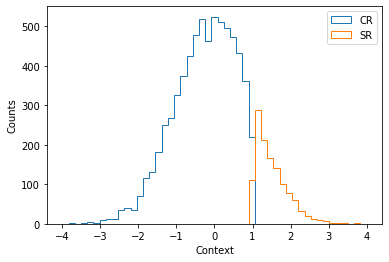

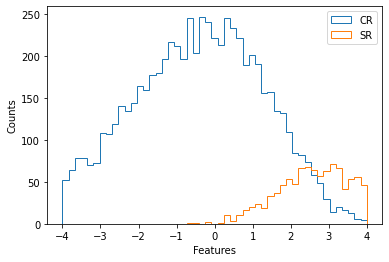

In [4]:
# plot the data

k = 2
bins = np.linspace(-4, 4, 50)

plt.figure()
plt.hist(data_dict[k].train_dataset_CR.context, bins = bins, label = "CR", histtype = "step")
plt.hist(data_dict[k].train_dataset_SR
.context, bins = bins, label = "SR", histtype = "step")
plt.legend()
plt.xlabel("Context")
plt.ylabel("Counts")
plt.show()


plt.figure()
plt.hist(data_dict[k].train_dataset_CR.features, bins = bins, label = "CR", histtype = "step")
plt.hist(data_dict[k].train_dataset_SR
.features, bins = bins, label = "SR", histtype = "step")
plt.legend()
plt.xlabel("Features")
plt.ylabel("Counts")
plt.show()

In [5]:
# flow model

flow_args = {"num_layers":1, "num_nodes": 128, "num_blocks":15, "num_bins":8}
lr = 1e-3
wd = 1e-3

flow_dict = {}
    
for k in k_list:
    flow_dict[k] = FlowLit(dim_features, dim_context, flow_args, lr, wd)


In [6]:
# train

for k in k_list:

    pl.seed_everything(SEED, workers=True)
    trainer = pl.Trainer(max_epochs=20, logger = wandb_logger, gpus = 1,
                          callbacks=[checkpoint_callback, progress_bar])
                        #accelerator="gpu", devices=2, strategy="ddp")
    trainer.fit(flow_dict[k], data_dict[k])

Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
wandb: Currently logged in as: radha-mastandrea (rmastand). Use `wandb login --relogin` to force relogin


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  502 K │
│ 2 │ flow      │ Flow               │  502 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 502 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 502 K                                                                                                
Total estimated model params size (MB): 2

Output()

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /global/home/users/rrmastandrea/bkg_extrapolation_AD/checkpoints/2023-03-14/8 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  502 K │
│ 2 │ flow      │ Flow               │  502 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 502 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 502 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  502 K │
│ 2 │ flow      │ Flow               │  502 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 502 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 502 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  502 K │
│ 2 │ flow      │ Flow               │  502 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 502 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 502 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  502 K │
│ 2 │ flow      │ Flow               │  502 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 502 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 502 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


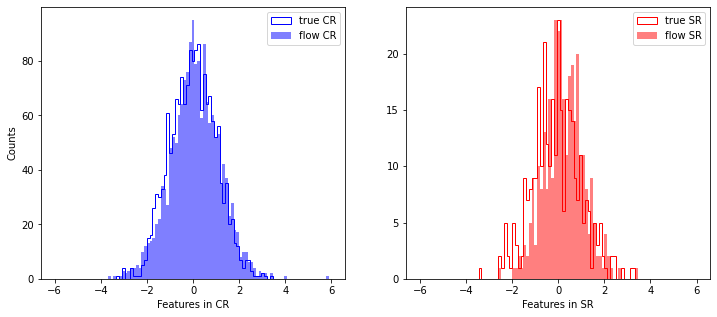

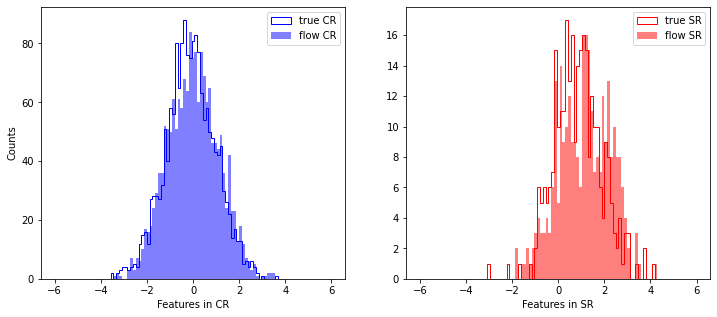

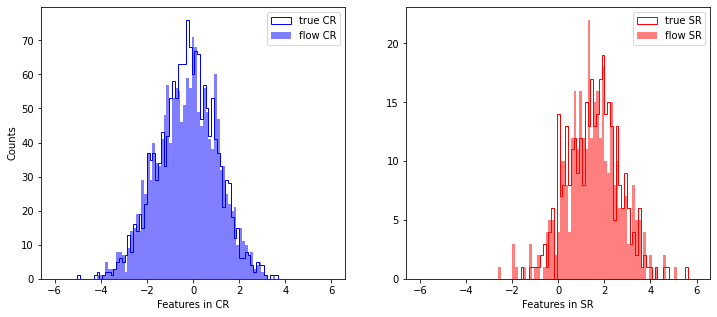

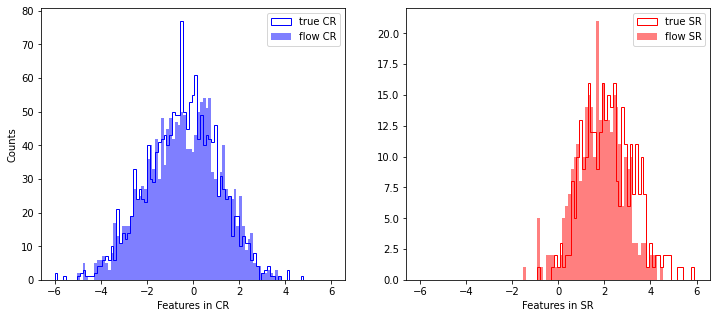

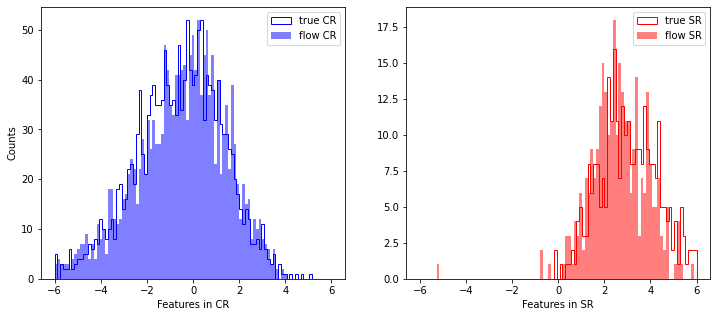

In [7]:
# check training

bins = np.linspace(-6, 6, 100)

for k in k_list:

    true_CR_features = data_dict[k].valid_dataset_CR.features
    true_SR_features = data_dict[k].valid_dataset_SR.features


    with torch.no_grad():

        flow_samples_CR = flow_dict[k].flow.sample(1, context=torch.tensor(data_dict[k].valid_dataset_CR.context)).numpy().reshape(-1, 1)
        flow_samples_SR = flow_dict[k].flow.sample(1, context=torch.tensor(data_dict[k].valid_dataset_SR.context)).numpy().reshape(-1, 1)

    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist(true_CR_features, bins = bins, label = "true CR", histtype = "step", color = "blue")
    ax[0].hist(flow_samples_CR, bins = bins, label = "flow CR", histtype = "bar", alpha = 0.5, color = "blue")
    ax[0].legend()
    ax[0].set_xlabel("Features in CR")
    ax[0].set_ylabel("Counts")


    ax[1].hist(true_SR_features, bins = bins, label = "true SR", histtype = "step", color = "red")
    ax[1].hist(flow_samples_SR, bins = bins, label = "flow SR", histtype = "bar", alpha = 0.5, color = "red")
    ax[1].legend()
    ax[1].set_xlabel("Features in SR")

    plt.show()




# 2D dataset

In [8]:
# Dataset

dim_features = 1
dim_context = 2
num_samples = 10000
k_list = [0, 0.2, 0.5, 0.8, 1, 1.5, 2]
theta = np.pi/4.0

data_dict = {}

for k in k_list:
    data_dict[k] = ToySingleDataModuleLit(dim_context, num_samples, k, theta)
    data_dict[k].setup()



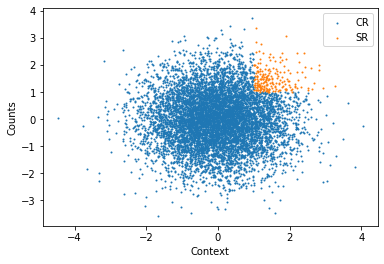

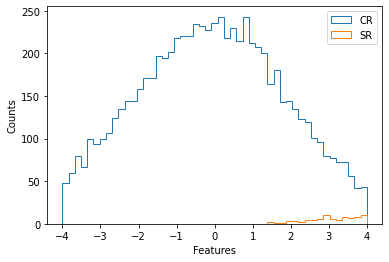

In [9]:
# plot the data

k = 2
bins = np.linspace(-4, 4, 50)

plt.figure()
plt.scatter(data_dict[k].train_dataset_CR.context[:,0], data_dict[k].train_dataset_CR.context[:,1], s = 1, label = "CR")
plt.scatter(data_dict[k].train_dataset_SR.context[:,0], data_dict[k].train_dataset_SR.context[:,1], s = 1, label = "SR")

plt.legend()
plt.xlabel("Context")
plt.ylabel("Counts")
plt.show()


plt.figure()
plt.hist(data_dict[k].train_dataset_CR.features, bins = bins, label = "CR", histtype = "step")
plt.hist(data_dict[k].train_dataset_SR
.features, bins = bins, label = "SR", histtype = "step")
plt.legend()
plt.xlabel("Features")
plt.ylabel("Counts")
plt.show()

In [11]:
# flow model

flow_args = {"num_layers":1, "num_nodes": 128, "num_blocks":15, "num_bins":8}
lr = 1e-3
wd = 1e-3

flow_dict = {}
    
for k in k_list:
    flow_dict[k] = FlowLit(dim_features, dim_context, flow_args, lr, wd)


In [12]:
# train

for k in k_list:

    pl.seed_everything(SEED, workers=True)
    trainer = pl.Trainer(max_epochs=20, logger = wandb_logger, gpus = 1,
                          callbacks=[checkpoint_callback, progress_bar])
                        #accelerator="gpu", devices=2, strategy="ddp")
    trainer.fit(flow_dict[k], data_dict[k])

Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  504 K │
│ 2 │ flow      │ Flow               │  504 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 504 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 504 K                                                                                                
Total estimated model params size (MB): 2

Output()

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /global/home/users/rrmastandrea/bkg_extrapolation_AD/checkpoints/2023-03-14/8 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  504 K │
│ 2 │ flow      │ Flow               │  504 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 504 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 504 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  504 K │
│ 2 │ flow      │ Flow               │  504 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 504 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 504 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  504 K │
│ 2 │ flow      │ Flow               │  504 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 504 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 504 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  504 K │
│ 2 │ flow      │ Flow               │  504 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 504 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 504 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  504 K │
│ 2 │ flow      │ Flow               │  504 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 504 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 504 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │  504 K │
│ 2 │ flow      │ Flow               │  504 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 504 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 504 K                                                                                                
Total estimated model params size (MB): 2

Output()

Global seed set to 8


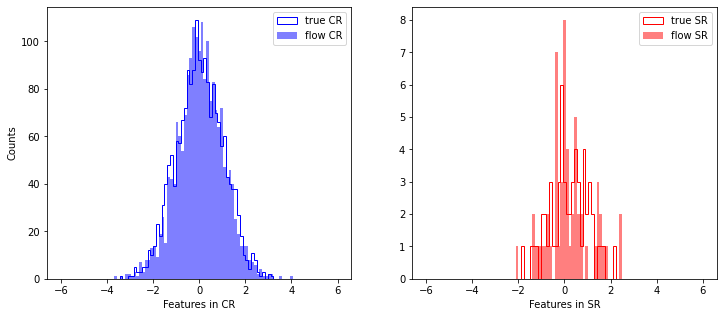

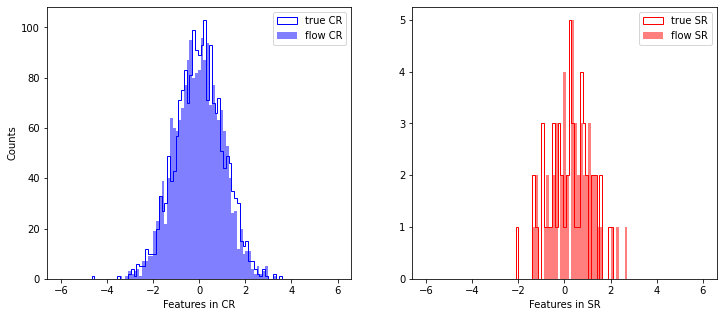

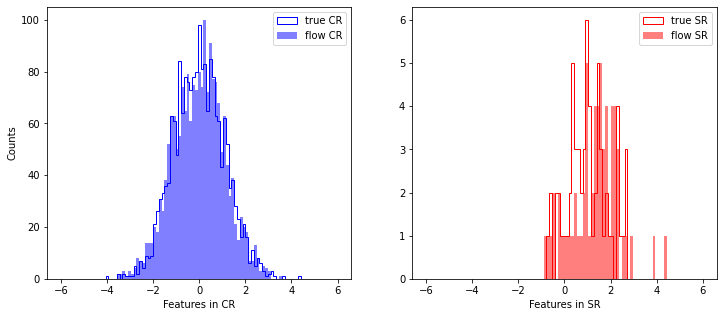

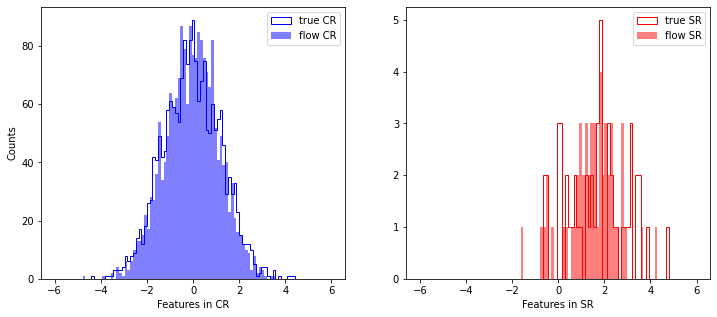

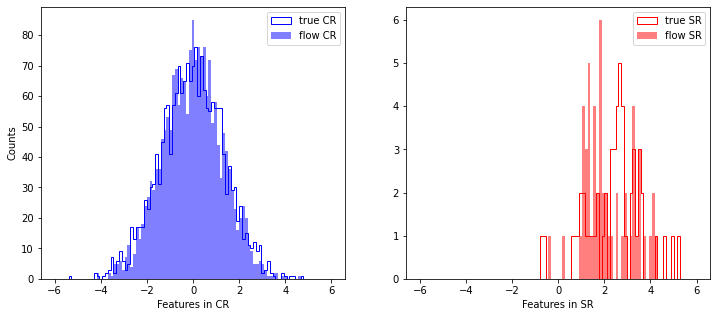

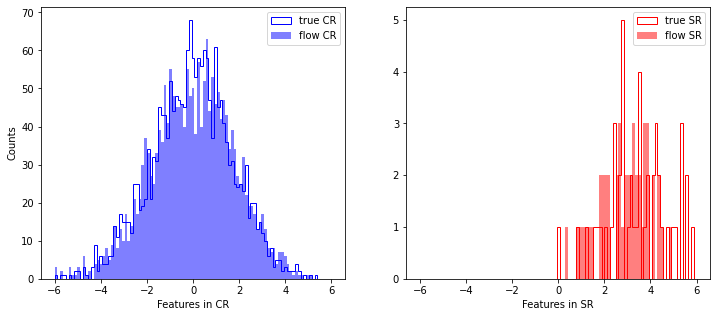

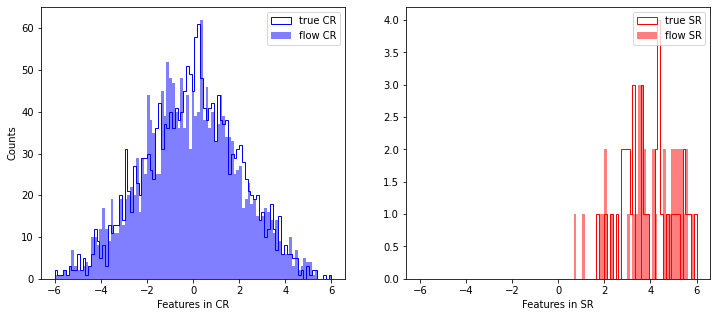

In [13]:
# check training

bins = np.linspace(-6, 6, 100)

for k in k_list:

    true_CR_features = data_dict[k].valid_dataset_CR.features
    true_SR_features = data_dict[k].valid_dataset_SR.features


    with torch.no_grad():

        flow_samples_CR = flow_dict[k].flow.sample(1, context=torch.tensor(data_dict[k].valid_dataset_CR.context)).numpy().reshape(-1, 1)
        flow_samples_SR = flow_dict[k].flow.sample(1, context=torch.tensor(data_dict[k].valid_dataset_SR.context)).numpy().reshape(-1, 1)

    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist(true_CR_features, bins = bins, label = "true CR", histtype = "step", color = "blue")
    ax[0].hist(flow_samples_CR, bins = bins, label = "flow CR", histtype = "bar", alpha = 0.5, color = "blue")
    ax[0].legend()
    ax[0].set_xlabel("Features in CR")
    ax[0].set_ylabel("Counts")


    ax[1].hist(true_SR_features, bins = bins, label = "true SR", histtype = "step", color = "red")
    ax[1].hist(flow_samples_SR, bins = bins, label = "flow SR", histtype = "bar", alpha = 0.5, color = "red")
    ax[1].legend()
    ax[1].set_xlabel("Features in SR")

    plt.show()


